# 2021 Tokyo-Olympics-Medals & Athlete-EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import geopandas
from wordcloud import WordCloud
import ipywidgets as widgets
from ipywidgets import interactive
import warnings
warnings.filterwarnings("ignore")
import os

medals_df = pd.read_excel('db/Medals.xlsx')

# Universal Downcasting Function for Dataframes
- For Memory Optimizaton and Utilization.

In [2]:
def downcastMemoryUsage(dataFrame):
    startMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is: {:.2f} MB'.format(startMemoryOptimization))
    subTypeInt = ['uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64']
    subTypeFloat = ['float16', 'float32', 'float64']
    for column in dataFrame.columns:
        columnType = str(dataFrame[column].dtypes)
        maximumColumn = dataFrame[column].max()
        minimumColumn = dataFrame[column].min()
        if 'int' in columnType:
            for element in subTypeInt:
                if minimumColumn > np.iinfo(element).min and maximumColumn < np.iinfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'float' in columnType:
            for element in subTypeFloat:
                if minimumColumn > np.finfo(element).min and maximumColumn < np.finfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'object' in columnType:
            if column =='date':
                dataFrame['date'] = pd.to_datetime(dataFrame['date'],format='%Y-%m-%d')
            else:
                numberOfUnique = len(dataFrame[column].unique())
                numberOfTotal = len(dataFrame[column])
                if numberOfUnique / numberOfTotal < 0.5:
                    dataFrame[column] = dataFrame[column].astype('category')
    endMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(endMemoryOptimization))
    print('Compressed by: {:.2f} %'.format(100*(startMemoryOptimization - endMemoryOptimization) / startMemoryOptimization))
    return dataFrame

In [3]:
downcastMemoryUsage(medals_df)

Memory usage of dataframe is: 0.01 MB
Memory usage after optimization is: 0.00 MB
Compressed by: 73.20 %


,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total
0,1,United States of America,39,41,33,113,1
1,2,People's Republic of China,38,32,18,88,2
2,3,Japan,27,14,17,58,5
3,4,Great Britain,22,21,22,65,4
4,5,ROC,20,28,23,71,3
...,...,...,...,...,...,...,...
88,86,Ghana,0,0,1,1,77
89,86,Grenada,0,0,1,1,77
90,86,Kuwait,0,0,1,1,77
91,86,Republic of Moldova,0,0,1,1,77


# Universal Basic Summary Function for Dataframes

In [4]:
def basicSummary(dataFrameForSummary):
    print(f'Shape : {dataFrameForSummary.shape}')
    summary = pd.DataFrame(dataFrameForSummary.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Num of Nulls'] = dataFrameForSummary.isnull().sum().values
    summary['Num of Unique'] = dataFrameForSummary.nunique().values
    summary['First Value'] = dataFrameForSummary.loc[0].values
    summary['Second Value'] = dataFrameForSummary.loc[1].values
    summary['Third Value'] = dataFrameForSummary.loc[2].values
    summary['Fourth Value'] = dataFrameForSummary.loc[3].values
    summary['Fifth Value'] = dataFrameForSummary.loc[4].values
    return summary

In [5]:
basicSummary(medals_df)

Shape : (93, 7)


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value,Third Value,Fourth Value,Fifth Value
0,Rank,uint8,0,67,1,2,3,4,5
1,Team/NOC,object,0,93,United States of America,People's Republic of China,Japan,Great Britain,ROC
2,Gold,int8,0,14,39,38,27,22,20
3,Silver,int8,0,17,41,32,14,21,28
4,Bronze,int8,0,21,33,18,17,22,23
5,Total,uint8,0,30,113,88,58,65,71
6,Rank by Total,uint8,0,30,1,2,5,4,3


In [6]:
medals_df

,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total
0,1,United States of America,39,41,33,113,1
1,2,People's Republic of China,38,32,18,88,2
2,3,Japan,27,14,17,58,5
3,4,Great Britain,22,21,22,65,4
4,5,ROC,20,28,23,71,3
...,...,...,...,...,...,...,...
88,86,Ghana,0,0,1,1,77
89,86,Grenada,0,0,1,1,77
90,86,Kuwait,0,0,1,1,77
91,86,Republic of Moldova,0,0,1,1,77


# Preparacion de los datos

## Top 10 de paises

In [7]:
df_medals_by_top_10_country = pd.DataFrame(medals_df.value_counts(), columns=['count'])
df_medals_by_top_10_country.reset_index(inplace=True)

# Total Medals
medals_by_top10_country = df_medals_by_top_10_country.sort_values('Total', ascending=False)
medals_by_top10_country = medals_by_top10_country.head(10)

## Medallas por cada pais

In [8]:
def generate_value_labels(top10_country_count, other_country_count):
    country_labels = []
    country_values = []

    for c in series_medals_for_every_country.index:
        if top10_country_count > 0:
            country_labels.append(c)
            country_values.append(series_medals_for_every_country[c])
            top10_country_count -= 1
        else:
            other_country_count += series_medals_for_every_country[c]
    country_labels.append("Other")
    country_values.append(other_country_count)
    return country_labels, country_values


medals_for_every_country = medals_df
series_medals_for_every_country = medals_for_every_country.groupby('Team/NOC')['Total'].sum().sort_values(ascending=False)
# Generando labels y valores para graficar
country_labels, country_values = generate_value_labels(10, 0)

## Medalla de Oro

In [9]:
medals_gold_every_country = medals_df
# Ordenando por el tipo de medalla
series_medals_gold_every_country = medals_gold_every_country.sort_values(by='Gold', ascending=False)

# Agrupando por la medalla de oro
series_medals_gold_every_country = medals_gold_every_country.groupby('Team/NOC')['Gold'].sum().sort_values(ascending=False)
series_medals_gold_every_country = series_medals_gold_every_country.head(10)

# Generando labels y valores para graficar
gold_country_labels, gold_country_values = generate_value_labels(10, 0)

## Medalla de Plata

In [10]:
medals_silver_every_country = medals_df
# Ordenando por el tipo de medalla
series_medals_silver_every_country = medals_silver_every_country.sort_values(by='Silver', ascending=False)

# Agrupando por la medalla de plata
series_medals_silver_every_country = medals_silver_every_country.groupby('Team/NOC')['Silver'].sum().sort_values(ascending=False)
series_medals_silver_every_country = series_medals_silver_every_country.head(10)

# Generando labels y valores para graficar
silver_country_labels, silver_country_values = generate_value_labels(10, 0)

## Medalla de Bronze

In [11]:
medals_bronze_every_country = medals_df
# Ordenando por el tipo de medalla
series_medals_bronze_every_country = medals_bronze_every_country.sort_values(by='Bronze', ascending=False)

# Agrupando por la medalla de plata
series_medals_bronze_every_country = medals_bronze_every_country.groupby('Team/NOC')['Bronze'].sum().sort_values(ascending=False)
series_medals_bronze_every_country = series_medals_bronze_every_country.head(10)

# Generando labels y valores para graficar
bronze_country_labels, bronze_country_values = generate_value_labels(10, 0)

# Graficas

## Top 10 paises

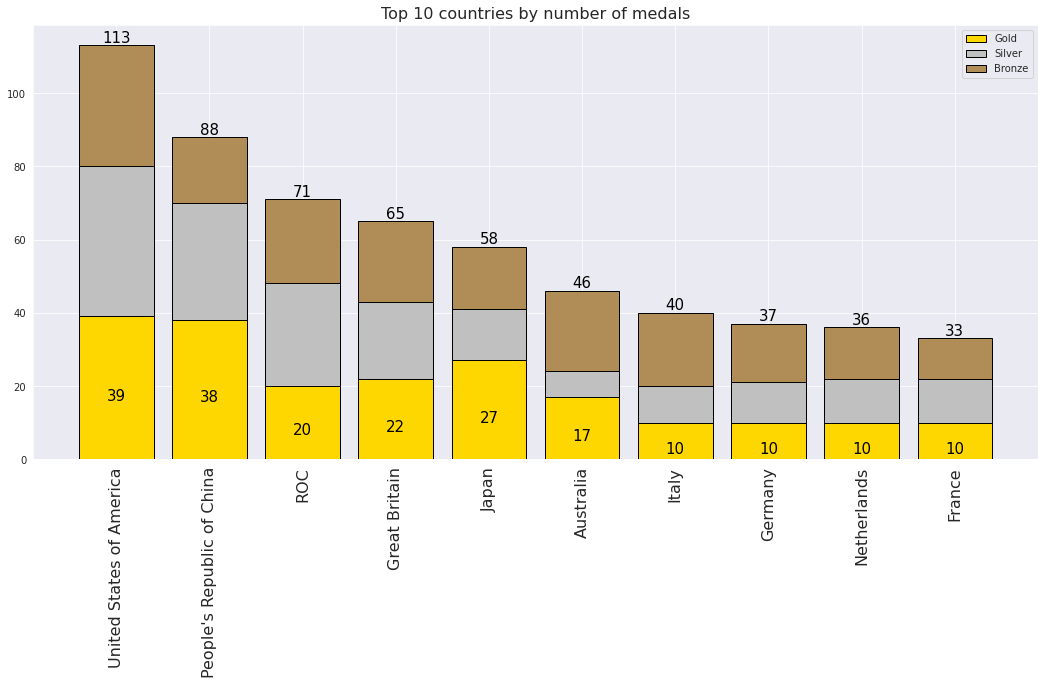

In [14]:
sns.set_style("darkgrid")
fig = plt.figure()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 3, box.height * 2])
p1 = plt.bar(medals_by_top10_country['Team/NOC'],medals_by_top10_country['Gold'],color='#FFD700',edgecolor='black')
p2 = plt.bar(medals_by_top10_country['Team/NOC'],medals_by_top10_country['Silver'], bottom=medals_by_top10_country['Gold'],color='#C0C0C0',edgecolor='black')
p3 = plt.bar(medals_by_top10_country['Team/NOC'],medals_by_top10_country['Bronze'], bottom=medals_by_top10_country['Gold']+medals_by_top10_country['Silver'],color='#b08d57',edgecolor='black')
plt.legend(["Gold", "Silver","Bronze"])
lenth=range(len(medals_by_top10_country))
plt.xticks(lenth,medals_by_top10_country['Team/NOC'], fontsize=16,rotation=90)
plt.title("Top 10 countries by number of medals", fontsize=16)
for r1,r2,r3 in zip(p1,p2,p3):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x()+r1.get_width()/2., h1+h2+h3, '%s'% (h1+h2+h3), ha = 'center', va='bottom',color='black', size=15)
for r1 in p1:
    h1 = r1.get_height()
    plt.text(r1.get_x()+r1.get_width()/2,h1/2, '%s'% (h1), ha = 'center',color='black',va='top', size=15)
plt.show()